In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

Text(0.5, 0, 'sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)')

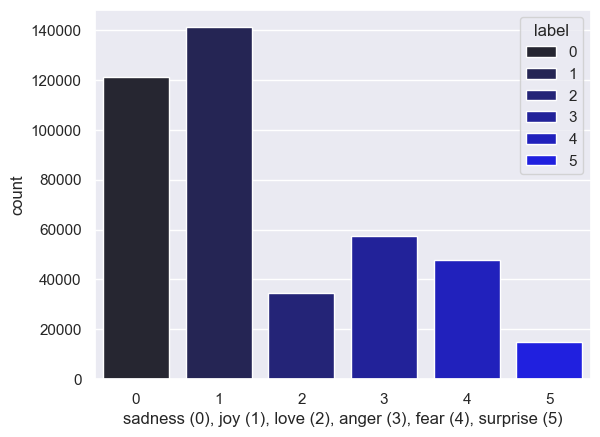

In [60]:
df = pd.read_csv('./twitter.csv', index_col=0)
sns.countplot(df, x='label', hue='label', palette='dark:blue')
plt.xlabel('sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)')
#mid = int(df.groupby('label').count().mean().iloc[0])

<Axes: xlabel='label', ylabel='count'>

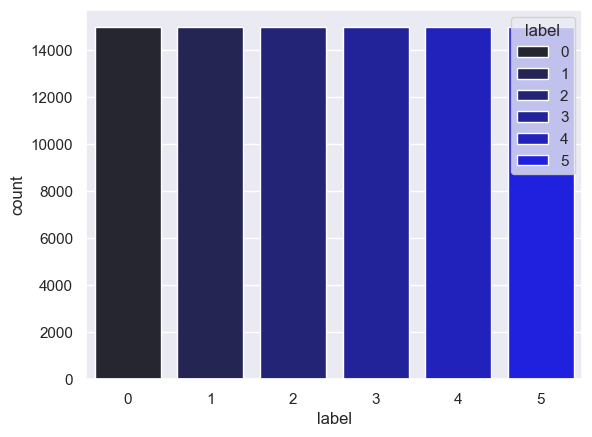

In [65]:
from sklearn.utils import resample

labeled = lambda i: df[df['label'] == i]
downsampled_df = pd.DataFrame(data=labeled(5))

for i in range(5):
      downsampled_class = resample(labeled(i),
                                   replace=False,
                                   n_samples=len(labeled(5)),
                                   random_state=42)
      downsampled_df = pd.concat([downsampled_df, downsampled_class])

df = downsampled_df
sns.countplot(df, x='label', hue='label', palette='dark:blue')

In [44]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation

def text_process(data):
    ps = PorterStemmer()
    result = [l for l in(data) if l.lower() not in punctuation]
    result = ''.join(result)
    result = ' '.join(word for word in result.split() if word.lower() not in(stopwords.words('english')))
    result = ' '.join(ps.stem(word) for word in word_tokenize(result))
    return result

df['text'].apply(text_process)
df

,text,label
8,im forever taking some time out to have a lie ...,5
89,i was feeling really overwhelmed,5
116,i really love reading bible because i can feel...,5
153,im feeling a bit amazed and grateful about hav...,5
157,i just sat there feeling this weird feeling an...,5
...,...,...
17568,i think about how much i am looking forward to...,4
296537,i wonder if everyone feels intimidated by me,4
411121,i started to feel anxious for longer periods o...,4
98494,i to feel suspicious,4


In [63]:
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

x = df.iloc[:, 0]
y = df.iloc[:, 1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('vec', CountVectorizer(ngram_range=(1,2), stop_words='english')),
    #('tfid', TfidfVectorizer()),
    ('clf', MultinomialNB())
    #('classifier', SGDClassifier(loss='huber', penalty='elasticnet', shuffle=False, random_state=42,
    #                      n_jobs=-1, epsilon=1, learning_rate='adaptive', eta0=0.5, alpha=0.0001))
])

        F1: 0.8059
  Accuracy: 0.8224
 Precision: 0.8271
    Recall: 0.8224


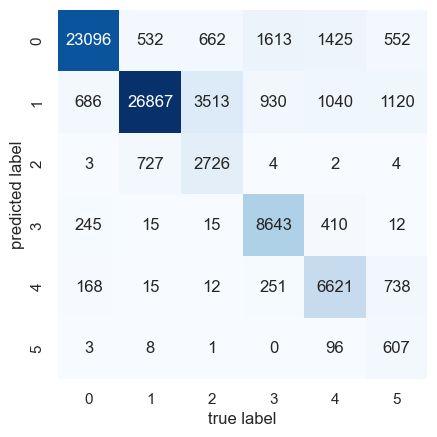

In [64]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')

f1 = round(f1_score(y_test, y_pred, average='weighted'), 4)
accuracy = round(accuracy_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
print(f"{'F1':>10}: {f1}\n"
      f"{'Accuracy':>10}: {accuracy}\n"
      f"{'Precision':>10}: {precision}\n"
      f"{'Recall':>10}: {recall}")


In [36]:
from sklearn.model_selection import GridSearchCV
parameters = {
    #'clf__n_estimators': [50, 100, 200],
    #'clf__learning_rate': [0.1, 0.5, 1.0],
    #'clf__estimator__alpha': [0.001, 0.001, 0.01]
    'clf__alpha': [n/100_000 for n in range(5, 15)]
    #'clf__loss': ['hinge', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    #'clf__loss': ['hinge', 'squared_hinge'],
    #'clf__penalty': ['elasticnet', 'l1', 'l2', None],
    #'clf__epsilon': [n/10 for n in range(11)],
    #'clf__learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    #'clf__eta0': [n/100 for n in range(1, 101, 10)]
}
gf_clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=1)
gs_clf = gf_clf.fit(x_train, y_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.9312600013914979
{'clf__alpha': 0.0001}
